# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

import lightgbm as lgb

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler, OrdinalEncoder

import time
import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv('autos.csv')
display(df.head())
display(df.info())
display(df.describe())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [8]:
print('Дубликатов:', df.duplicated().sum())
df.isna().sum()

Дубликатов: 4


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Видим, что в исходном датасете есть 4 полных дубликата - удалим их, и пропуски в категориальных признаках - заполним их заглушкой.

Столбцы DateCrawled, DateCreated, NumberOfPictures, PostalCode, LastSeen неинформативны и не помогут в предсказании стоимости автомобиля, удалим их.

Столбцы RegistrationYear, Power содержат слишком маленькие/большие значения. Столбцы Price, RegistrationMonth содержат нули.

In [9]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
df = df.drop_duplicates().reset_index(drop=True)
df.columns = ['price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326826 entries, 0 to 326825
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               326826 non-null  int64 
 1   vehicle_type        291577 non-null  object
 2   registration_year   326826 non-null  int64 
 3   gearbox             309248 non-null  object
 4   power               326826 non-null  int64 
 5   model               308294 non-null  object
 6   kilometer           326826 non-null  int64 
 7   registration_month  326826 non-null  int64 
 8   fuel_type           295704 non-null  object
 9   brand               326826 non-null  object
 10  not_repaired        260399 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.4+ MB


**Цена**

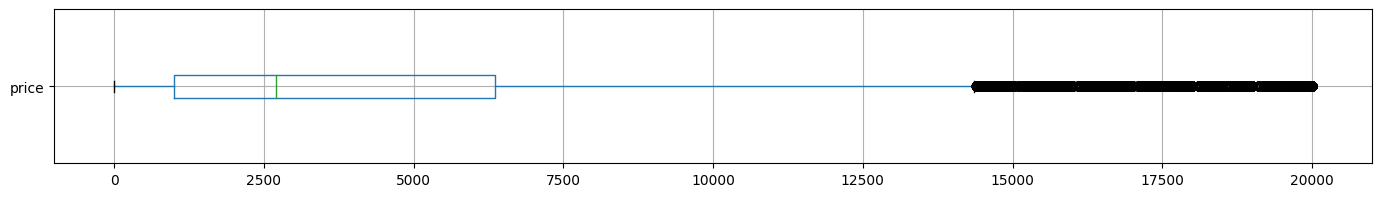

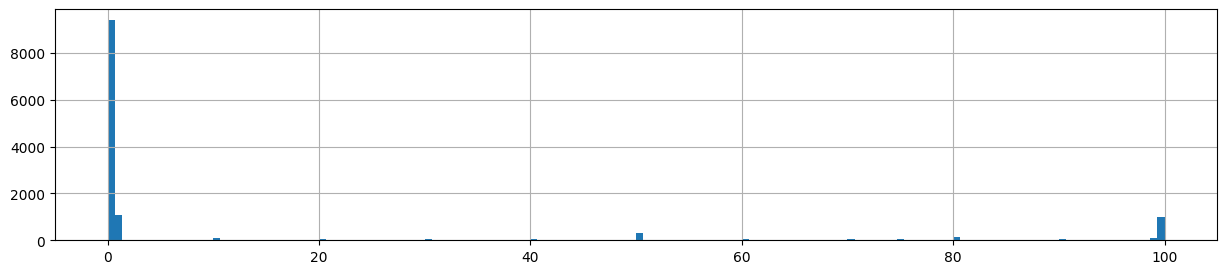

In [10]:
df.boxplot(column='price', figsize=(17,2), vert=False);
plt.show()
df.price.hist(bins = 150, figsize = (15,3), range=(0,100));

Слишком низкая цена подозрительна, максимальная цена может быть любой, но слишком длинный хвост может повлиять на корректность обучения модели.

In [11]:
df = df.query('100 <= price < 15000')

**Год регистрации**

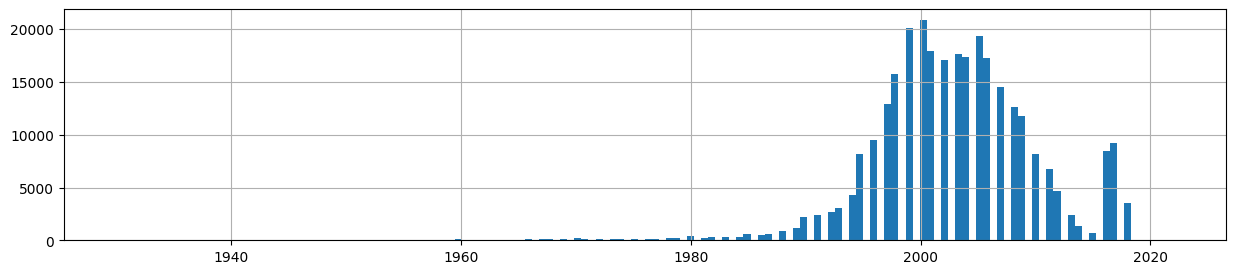

In [12]:
df.registration_year.hist(bins = 150, figsize = (15,3), range=(1930,2022));

Анкеты скачивали с сайта в 2016 г., значит год регистрации не может быть позже него. Нижнюю границу обозначим 1980 годом.

In [13]:
df = df.query('1980 <= registration_year < 2016')

**Месяц регистрации**

Нули в столбце с месяцем регистрации авто заполним рандомными значениями 1-12.

In [14]:
df.loc[df['registration_month'] == 0, 
             'registration_month'] = df['registration_month'].apply(lambda x: np.random.randint(1, 12))

**Мощность**

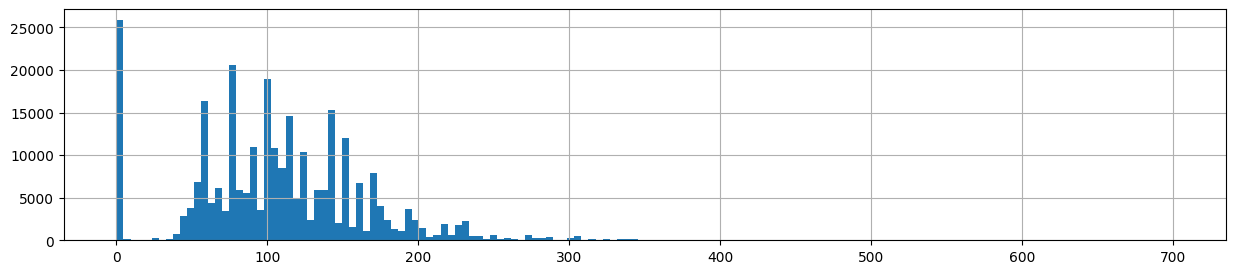

In [15]:
df.power.hist(bins = 150, figsize = (15,3), range=(0,700));

Современных автомобилей c мощностью меньше 40 л.с. не так много - это будет нижняя граница. Верхнюю границу поставим в 400 л.с.

In [16]:
df = df.query('40 <= power < 400')

In [17]:
df.describe()

,price,registration_year,power,kilometer,registration_month
count,249691.000000,249691.000000,249691.000000,249691.000000,249691.000000
mean,4218.677465,2002.406058,117.769439,130475.327505,6.355708
std,3680.903227,5.462184,49.744013,34760.764496,3.338837
min,100.000000,1980.000000,40.000000,5000.000000,1.000000
25%,1300.000000,1999.000000,75.000000,125000.000000,3.000000
50%,2990.000000,2003.000000,109.000000,150000.000000,6.000000
75%,6250.000000,2006.000000,143.000000,150000.000000,9.000000
max,14999.000000,2015.000000,399.000000,150000.000000,12.000000


**Пропуски**

Заполним пропуски заглушкой 'unknown'.

In [18]:
df[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'not_repaired']] = df[
    ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'not_repaired']].fillna('unknown')

df.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
dtype: int64

## Обучение моделей

In [19]:
#создадим скорер
def rmse(target,predictions):
    mse = mean_squared_error(target, predictions)
    return mse ** 0.5

rmse_scorer = make_scorer(rmse, greater_is_better=False)

**Линейная регрессия**

In [20]:
#закодируем категориальные переменные в количественные
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head()

,price,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknown,not_repaired_yes
2,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,6,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,7,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,10,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
6,2200,2004,109,150000,8,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
#выделим целевой признак и разделим выборки
features_ohe = df_ohe.drop('price', axis=1)
target_ohe = df_ohe['price']
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.25, random_state=12345)

print(features_train_ohe.shape)
print(features_test_ohe.shape)

(187268, 310)
(62423, 310)


In [22]:
#отмасштабируем признаки
scaler = StandardScaler()
numeric = ['registration_year','power', 'kilometer', 'registration_month']
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

In [23]:
%%time
lin = cross_val_score(LinearRegression(), features_train_ohe, target_train_ohe, cv=5, scoring=rmse_scorer)

print('RMSE: {}.'.format(-lin.mean(), lin))

RMSE: 1932.6132075178357.
CPU times: total: 1min 25s
Wall time: 34.7 s


In [24]:
%%time
#обучим модель
model = LinearRegression()
fit_time_start = time.time()
model.fit(features_train_ohe, target_train_ohe)
fit_time_end = time.time()
rmse_lin = (mean_squared_error(target_train_ohe, model.predict(features_train_ohe))**0.5)
predict_time_end = time.time()

print('RMSE:', rmse_lin)

RMSE: 1927.843641777253
CPU times: total: 21.4 s
Wall time: 7.14 s


In [25]:
lin_fit_time = fit_time_end - fit_time_start
lin_pred_time = predict_time_end - fit_time_end

**Случайный лес**

In [26]:
#выделим целевой признак и разделим выборки
target_enc = df['price']
features_enc = df.drop('price', axis=1)

features_train_enc, features_test_enc, target_train_enc, target_test_enc = train_test_split(
    features_enc, target_enc, test_size=0.25, random_state=12345) 

print(features_train_enc.shape)
print(features_test_enc.shape)

(187268, 10)
(62423, 10)


In [27]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
categorical = ['vehicle_type', 'model', 'fuel_type', 'brand', 'not_repaired','gearbox']
encoder.fit(features_train_enc[categorical])
features_train_enc[categorical] = encoder.transform(features_train_enc[categorical])
features_test_enc[categorical] = encoder.transform(features_test_enc[categorical])

In [28]:
%%time

#обучим модель
model = RandomForestRegressor(random_state=12345)
params_forest = {'n_estimators': range(1, 15), 'max_depth': range(1,10)} 
grid_forest = GridSearchCV(model, param_grid=params_forest, cv=5, scoring=rmse_scorer, n_jobs=-1)
fit_time_start = time.time()
grid_forest.fit(features_train_enc, target_train_enc)
fit_time_end = time.time()
rmse_forest = rmse(target_train_enc, grid_forest.best_estimator_.predict(features_train_enc))
predict_time_end = time.time()

print('RMSE:', rmse_forest)
print('Параметры {}'.format(grid_forest.best_params_))

RMSE: 1533.1755049024678
Параметры {'max_depth': 9, 'n_estimators': 14}
CPU times: total: 16 s
Wall time: 6min 37s


In [29]:
forest_fit_time = fit_time_end - fit_time_start
forest_pred_time = predict_time_end - fit_time_end

**LightGBM**

In [30]:
#выделим целевой признак, разделим выборки
features_lgb = df.drop('price', axis=1)
target_lgb = df['price']

features_train_lgb, features_test_lgb, target_train_lgb, target_test_lgb = train_test_split(
    features_lgb, target_lgb, test_size=0.25, random_state=12345) 

In [31]:
#поменяем тип данных категориальных признаков
features_train_lgb[categorical] = features_train_lgb[categorical].astype('category')
features_test_lgb[categorical] = features_test_lgb[categorical].astype('category')

In [32]:
%%time
#обучим модель
lgb_model = lgb.LGBMRegressor(random_state=12345)
parametrs = {'n_estimators': [10, 30, 50],
             'learning_rate': [0.03, 0.1],
             'max_depth': [1, 10, 15],}
grid_lgb = GridSearchCV(lgb_model, param_grid=parametrs, cv=5, scoring=rmse_scorer, n_jobs=-1)
fit_time_start = time.time()
grid_lgb.fit(features_train_lgb, target_train_lgb)
fit_time_end = time.time()
rmse_lgb = rmse(target_train_lgb, grid_lgb.best_estimator_.predict(features_train_lgb))
predict_time_end = time.time()

print('RMSE:', rmse_lgb)
print('Параметры {}'.format(grid_lgb.best_params_))

RMSE: 1326.7947240898689
Параметры {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50}
CPU times: total: 4.67 s
Wall time: 23.6 s


In [33]:
lgb_fit_time = fit_time_end - fit_time_start
lgb_pred_time = predict_time_end - fit_time_end

## Анализ моделей

In [34]:
results = pd.DataFrame({'Модель':['Линейная регрессия', 'Случайный лес', 'LightGBM'],
                       'RMSE': [rmse_lin, rmse_forest, rmse_lgb],
                       'Fit time': [lin_fit_time, forest_fit_time, lgb_fit_time],
                       'Predict time': [lin_pred_time, forest_pred_time, lgb_pred_time]})

display(results)

,Модель,RMSE,Fit time,Predict time
0,Линейная регрессия,1927.843642,6.797381,0.343669
1,Случайный лес,1533.175505,396.702944,0.374346
2,LightGBM,1326.794724,23.275857,0.297993


**Проверка лучшей модели**

In [35]:
lgb_test = lgb.LGBMRegressor(random_state=12345, **grid_lgb.best_params_, n_jobs=-1)
lgb_test.fit(features_train_lgb, target_train_lgb)
rmse_lgb_test = rmse(target_test_lgb, lgb_test.predict(features_test_lgb))

print('RMSE:', rmse_lgb_test)

RMSE: 1348.1563095035858


**Проверка на адекватность**

In [36]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(features_train_lgb, target_train_lgb)
rmse_dummy = rmse(target_test_lgb, dummy.predict(features_test_lgb))

print('RMSE:', rmse_dummy)

RMSE: 3682.0619349786452


## Вывод

Для предсказания рыночной стоимости автомобиля на основе технических характеристик, комплектации и цен других автомобилей были построены модели линейной регрессии, случайного леса и градиентного бустинга. Анализ работы моделей показал:
- модель линейной регрессии обучается быстрее всего, но предсказывает с наименьшей точностью
- модель случайного леса обучается дольше всего, но быстрее всего предсказывает, точность предсказания средняя
- LightGBM имеет средние показатели по скорости обучения и предсказания, но наилучший результат по метрике RMSE.

Исходя из критериев заказчика, наиболее оптимальной по характеристикам моделью является LightGBM.